##### Authors: 
Michael Poli & Stefano Massaroli

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pyPH.numpy_simple import *

from scipy.integrate import odeint
from sklearn.model_selection import train_test_split

# plotting package
#from matplotlib2tikz import save as tikz_save

# Generate blob data
Two classes: $\mathcal{C}_1$ and  $\mathcal{C}_2$

In [3]:
# Standard deviations of class distributions
sigma_C1 = 0.1
sigma_C2 = 0.1

# Means of the class distributions
mu_C1 = 0.6
mu_C2 = 0.25

# Number of samples of each class
N_C1 = 1000
N_C2 = 1000

In [4]:
np.random.seed(1)
C1 = np.random.multivariate_normal([0.6,0.7], [[0.025,0.0],[0.0,0.01]], N_C1)
np.random.seed(2)
C2 = np.random.multivariate_normal([0.1,0.2], [[0.025,-0.00],[-0.00,0.01]], N_C2)

X = np.vstack((C1,C2))

# Dataset generation (blobs)

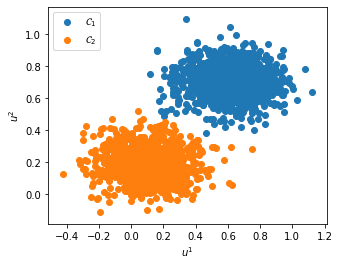

In [5]:
plt.figure(figsize=(5,4))
plt.scatter(C1[:,0],C1[:,1],label='$\mathcal{C}_1$', rasterized=False);
plt.scatter(C2[:,0],C2[:,1],label='$\mathcal{C}_2$', rasterized=False);
plt.xlabel("$u^1$")
plt.ylabel("$u^2$")
plt.legend()
#plt.savefig('dataset.eps', format='eps', dpi=300);
#tikz_save("dataset.tex");

### Labels

In [6]:
y1 = np.hstack((np.ones((N_C1,1)),np.zeros((N_C1,1))))
y2 = np.hstack((np.zeros((N_C2,1)),np.ones((N_C2,1))))

y = np.vstack((y1,y2))

### Train/Test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

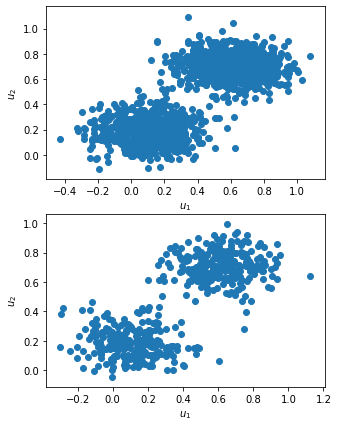

In [8]:
plt.figure(figsize=(5,7))
plt.subplot(211)
plt.scatter(X_train[:,0],X_train[:,1], rasterized=False)
plt.xlabel("$u_1$")
plt.ylabel("$u_2$")
plt.subplot(212)
plt.scatter(X_test[:,0],X_test[:,1], rasterized=False)
plt.xlabel("$u_1$")
plt.ylabel("$u_2$")
#
plt.savefig('traintestn.eps', format='eps', dpi=300)

# Port-Haltonian NN (PHNN)

- Neural Network model: $y = f(u,\omega(t))$ 

- Regularized $\mathcal{L}_2$ Loss function: $\mathcal{J} = a\|\hat{y}-f(u,\omega(t))\|_2^2 + b\| \dot{\omega}\|_2^2+c\|{\omega}\|_2^2$ with $a,b,c\in\mathbb{R}^+$ (every minima of $\mathcal{J}$ is placed in $\dot{\omega} = 0$)

- "state" vector $x = \begin{bmatrix}\omega&\dot{\omega}\end{bmatrix}^\top$

- Gradient of $\mathcal{J}$: $\partial_x\mathcal{J} = \begin{bmatrix}\partial_\omega\mathcal{J}&\partial_\dot{\omega}\mathcal{J}\end{bmatrix}$ (row vector)

- Weights dynamics: 
\begin{align}
\begin{bmatrix}\dot{\omega}\\\ddot{\omega}\end{bmatrix} & = \begin{bmatrix}0&I_n\\-I_n&-B\end{bmatrix}\begin{bmatrix}\partial_\omega\mathcal{J}\\\partial_\dot{\omega}\mathcal{J}\end{bmatrix}\\
\Leftrightarrow  \dot{x} & = \begin{bmatrix}0&I_n\\-I_n&-B\end{bmatrix}(\partial_x\mathcal{J})^\top
\end{align}
where $B=B^\top>0$

### Simple model

Neural network model: $\begin{bmatrix}y_1\\y_2\end{bmatrix} =\begin{bmatrix}w_{11}u_1 + w_{12}u_2 + w_{13}\\w_{21}u_1 + w_{22}u_2 + w_{23}\end{bmatrix}$

### Training of a single $(\hat{u},\hat{y})$ tuple

In [9]:
# Initialize parameters for numerical integration
n = 6
t = np.linspace(0,10,100)
x0 = np.zeros((2*n))
u = [0.6,0.6]
yh = [1.,0.]
beta = 0.5
a = 1.
b = 1
c = 0.
x0 = [0.6,-2.3,-0.1,-1.1,-1.2,0.3,-1.2,0.3,0.2,1.6,-0.4,1.6]

In [10]:
sol = odeint(hamiltonian_model, x0, t, args=(u,yh,beta,a,b,c,n))

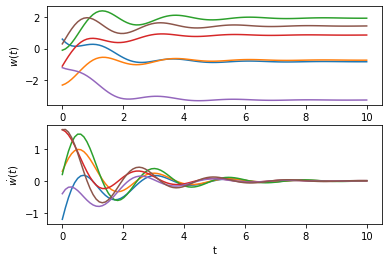

In [11]:
# Plot Weights
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(211)
plt.plot(t,sol[:,:n]);
plt.xlabel("$t$")
plt.ylabel("$w(t)$")
plt.subplot(212)
plt.plot(t,sol[:,n:2*n]);
plt.xlabel("t")
plt.ylabel("$\dot{w}(t)$")
plt.savefig('weightsLC.eps', format='eps', dpi=300)
#tikz_save('weightsLC.tex')

In [12]:
# computing output
N = len(sol)
y = np.zeros((N,2))
J = np.zeros((N,1))
for i in range(N):
    y[i,:] = simple_net(u,sol[i])
    J[i] = loss(sol[i],u,yh,a,b,c,n)

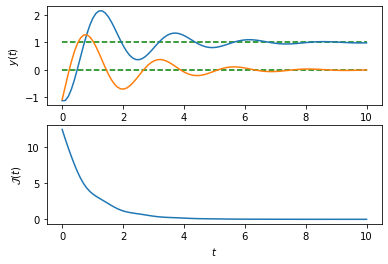

In [13]:
# Plot output 
yh1 = yh[0]*np.ones((N,1))
yh2 = yh[1]*np.ones((N,1))

plt.figure()
plt.subplot(211)
plt.plot(t, yh1, color='green', linestyle='dashed')
plt.plot(t, yh2, color='green', linestyle='dashed')
plt.plot(t, y)
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.subplot(212)
plt.plot(t,J)
plt.xlabel("$t$")
plt.ylabel("$\mathcal{J}(t)$")
plt.savefig('out_loss.eps', format='eps', dpi=300)
#tikz_save('out_lossLC.tex')

#### Evaluate the effect of the hyperparameter. $c$

In [14]:
t = np.linspace(0,5,3000)
x0 = np.zeros((2*n))
u = [0.6,0.6]
yh = [1.,0.]
beta = 3
a = 1.
b = 1.
n = 6

x0 = [0.6,-2.3,-0.1,-1.1,-1.2,0.3,-1.2,0.3,0.2,1.6,-0.4,1.6]

N = 100 # number of trials
c0 = 0
cN = 1
c_it = np.linspace(c0,cN,N)
err = np.zeros((N,1))
norm = np.zeros((N,1))
for i in range(N):
    c = c_it[i]
    sol = odeint(hamiltonian_model, x0, t, args=(u,yh,beta,a,b,c,n))
    temp = sol[-1]
    err[i] = loss(sol[-1],u,yh,1.,1.,0.,n)
    norm[i] = np.linalg.norm(temp[0:n])

Text(0, 0.5, '$e_r$, $\\mathcal{J}(t_f)$')

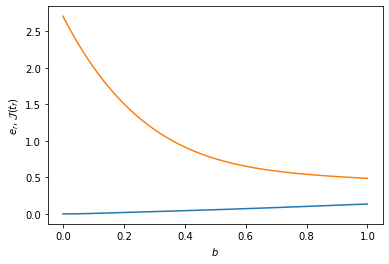

In [15]:
plt.figure()
plt.plot(c_it,err)
plt.plot(c_it,norm)
plt.xlabel("$b$")
plt.ylabel("$e_r$, $\mathcal{J}(t_f)$")
#tikz_save('reg.tex')

# Training on the entire dataset
Training on the whole dataset

In [16]:
n_samples = 2000
X_tr = np.array(X_train[:n_samples], dtype='float')
y_tr = np.array(y_train[:n_samples], dtype='float')

### Method #1: Sequential "Update & Converge" training
- initialize: weights, first IN and OUT ($u,\hat{y}$) of the dataset 
- Integrate for a while (until convergence)
- Feed a new IN-OUT
- Integrate again
- repeat

In [ ]:
bs = 1
epochs = 100

x0 = [0.6,-2.3,-0.1,-1.1,-1.2,0.3,-1.2,0.3,0.1,1.6,-0.4,1.6]

a = 1.
b = 1.
c = 0.001

beta = 100.
n = 6
t = np.linspace(0, 0.1, 10)

tf, xf, J, xep, Jep = train(X_tr,y_tr,bs,epochs,x0,a,b,c,beta,n,t);

#### Weight trajectories & Loss

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(tf,xf[:,:n]);
plt.xlabel("$t$")
plt.ylabel("$w(t)$")
plt.subplot(312)
plt.plot(tf,xf[:,n:2*n]);
plt.xlabel("$t$")
plt.ylabel("$\dot{w}(t)$")
plt.subplot(313)
plt.plot(tf,J);
plt.xlabel("$t$")
plt.ylabel("$\mathcal{J}(t)$")
#plt.savefig('weights.eps', format='eps', dpi=300)

#tikz_save('trj_seq.tex')

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(xep[:,:n]);
plt.xlabel("$t$")
plt.ylabel("$w(t)$")
plt.subplot(312)
plt.plot(xep[:,n:2*n]);
plt.xlabel("$t$")
plt.ylabel("$\dot{w}(t)$")
plt.subplot(313)
plt.plot(Jep);
plt.xlabel("$t$")
plt.ylabel("$\mathcal{J}(t)$")

#tikz_save('TrainEpochLC.tex')

#### Decision Boundary Plot

(-0.04282534578669561, 0.9917308762873107)

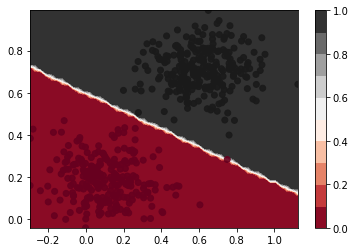

In [28]:
x_range = [X_test.min(0)[0],X_test.max(0)[0]]
y_range = [X_test.min(0)[1],X_test.max(0)[1]]
Np = 50
u1 = np.linspace(x_range[0],x_range[1],Np)
u2 = np.linspace(y_range[0],y_range[1],Np)
U1, U2 = np.meshgrid(u1, u2)
Y = np.zeros((Np,Np))

for i in range(Np):
    for j in range(Np):
        u = [U1[i,j],U2[i,j]]
        y_ij = SimpleNet(u,xf[-1])
        if y_ij[0]>y_ij[1]:
            Y[i,j] = 1
        if (y_ij[0]>=0.499) and (y_ij[0]<=0.509):
            Y[i,j] = y_ij[0]
plt.figure()
plt.contourf(U1, U2, Y,10,cmap='RdGy')
plt.colorbar();
plt.scatter(X_test[:,0],X_test[:,1],c=y_test[:,0],cmap='RdGy',alpha = 0.9)
plt.xlim(x_range)
plt.ylim(y_range)

Text(0, 0.5, '$u_2$')

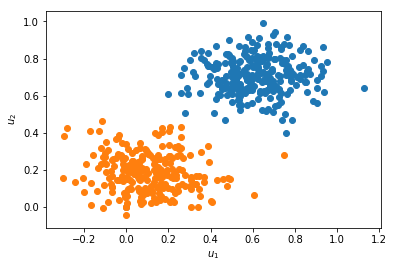

In [29]:
############ THIS PART IS FOR LATEX PLOTTING PURPOSES ONLY ####################
# Save DECISION BOUNDARY data in a .dat file
U1a = U1.reshape(int(Np*Np),1)
U2a = U2.reshape(int(Np*Np),1)
Ya = Y.reshape(int(Np*Np),1)

bound = np.hstack((U1a,np.hstack((U2a,Ya))))
np.savetxt('Boundary.dat', bound, fmt=['%.3f','%.3f','%.3f'])

# Save TEST SET data in .tex file
C1_test = np.array([0,0])
C2_test = np.array([0,0])
for i in range(len(X_test)):
    if y_test[i,0] == 1:
        C1_test = np.vstack((C1_test,X_test[i]))
    else:
        C2_test = np.vstack((C2_test,X_test[i]))
plt.scatter(C1_test[:,0],C1_test[:,1], rasterized=False)
plt.scatter(C2_test[:,0],C2_test[:,1], rasterized=False)
plt.xlabel("$u_1$")
plt.ylabel("$u_2$")
#tikz_save('TestScatterLC.tex')

## Method #2: Batch Training 

We train on a batch of arbitrary size

Example: whole dataset

Given
\begin{equation}
u = [u_1,u_2,\dots,u_i,\dots,u_N]\quad \hat{y} = [\hat{y}_1,\hat{y}_2,\dots,\hat{y}_i,\dots,\hat{y}_N]
\end{equation}
Rename $\mathcal{J}$: 
\begin{equation}
\mathcal{J} = \frac{1}{N}\sum_{i=1}^N\mathcal{J}_i(u_i,y_i,\omega(t))
\end{equation}
where
\begin{equation}
\mathcal{J}_i(u_i,y_i,\omega(t)) =  a\|\hat{y}_i-f(u_i,\omega(t))\|_2^2 + b\|\dot{\omega}\|_2^2 + c\|{\omega}\|_2^2
\end{equation}

### Train on the whole dataset

In [30]:
# Initialise parameters for numerical integration
t = np.linspace(0, 60, 600)
#x0 = np.array(np.random.randn(2*n))
# fixed randomization
x0 = [0.63248614,-2.28817298,-0.09513922,-1.08199499,-1.23973685,0.3197053,
      -1.21213162,0.29433111,0.07164353,1.57434972,-0.36218658,1.60029132]

U = X_tr 
Yh = y_tr
beta = 0.1
a = 1.
b = 1.
c = 0.01
n = 6
bs = 1000

In [31]:
sol = odeint(HamModBatch, x0, t, args=(bs,U,Yh,beta,a,b,c,n))

### Weight trajectories

Text(0, 0.5, '$\\dot{\\omega}(t)$')

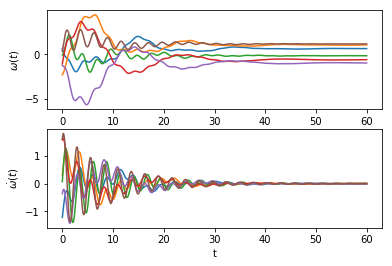

In [32]:
plt.figure()
plt.subplot(211)
plt.plot(t,sol[:,:n]);
plt.xlabel("t")
plt.ylabel("$\omega(t)$")
plt.subplot(212)
plt.plot(t,sol[:,n:2*n]);
plt.xlabel("t")
plt.ylabel("$\dot{\omega}(t)$")

#### Loss

Text(0.5, 1.0, 'Training loss')

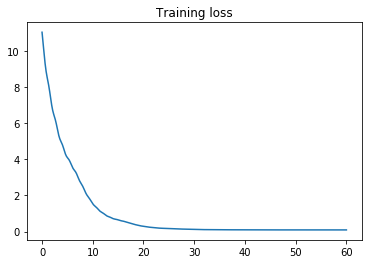

In [34]:
 N = len(sol)
J = np.zeros((N,1))
for i in range(N):
    J[i] = LossBatch(bs,sol[i],U,Yh,a,b,c,n)
plt.figure()
plt.plot(t,J)
plt.title("Training loss")